## Project Description
This module explains how to apply neural networks to the Kaggle OTTO Group Challenge and get the log loss score on the test data lower than 0.49 which was earlier achieved and described by applying Gradient Boosting. For information on the data set, please follow the link https://github.com/mayank-g20/Academic-Projects/blob/master/Gradient%20Boosting.pdf

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam,SGD,Adagrad
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import SVG

/Users/mayank/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mayank/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/mayank/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


# Data (Kaggle OTTO  Group challenge)

In [2]:
X = pd.read_csv("/Users/mayank/Documents/College Documents/Q3 Courses/Machine Learning/Course Project/supervized_classification_data/train_sample.csv")
#X.drop('id', axis=1, inplace=True)
print(X.shape)
np.random.seed(1)
# Shuffle data. It is originally oredered by class
X = X.reindex(np.random.permutation(X.index))

(41244, 94)


In [3]:
X.head(5)

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
17009,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
543,1,0,0,1,0,0,0,1,2,0,...,0,1,0,1,0,0,0,2,0,0
20763,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
17705,1,0,0,2,0,0,2,0,0,0,...,1,1,0,1,4,1,1,3,1,3
24340,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,1,7


This is a multiclass classification problem. 

Keras loss function for this problem is *'categorical_crossentropy'* (multiclass logloss). 

##### Also note that for multi-class identification problems, it is advisable to use log loss as an evaluation parameter as compared to the accuracy values.

There is important note in the manual:  <br>
when using the *'categorical_crossentropy'* loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros except for 1 at the index corresponding to the class of the sample). 

In order to convert integer targets into categorical targets, you can use Keras utility *'to_categorical'*:

`*from keras.utils import to_categorical*`
`*categorical_labels = to_categorical(int_labels, num_classes=None)*`

The target variable initially is in string format:

In [4]:
X.target[:6]

17009    1
543      0
20763    1
17705    3
24340    7
24643    6
Name: target, dtype: int64

The target data is in integer format, we will convert them to ctegorical targets

In [5]:
# Extract target
# Encode it to make it manageable by ML algo, convert to np.int32
y = X.target.values
encoder = LabelEncoder()
y = encoder.fit_transform(y).astype(np.int32)
num_classes = len(encoder.classes_)
# convert class vectors to binary class matrices
y = to_categorical(y, num_classes)

# Remove target from train
X.drop('target', axis=1, inplace=True)

y[:6,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.]])

It was noticed during competition that logarithmic transfrom improves performance of most of ML algrithms. Transform the data and convert them to numpy array.

In [6]:
num_features = X.shape[1]
# log transform to decrease large values affect
X = np.log(1+X.values)

# The baseline model

Start tunning sequential network with two hidden layers and dropout layers after each of them. 

The following function creates such network.

### Dropout explanation for the below use case:
+ Dropout is a regularization technique for neural network models.

+ Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

+ As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

+ You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

+ The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

Ref: https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

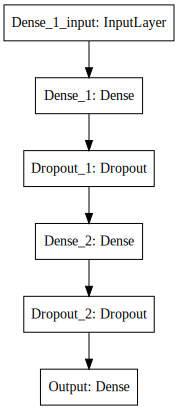

In [7]:
def getModel(dropout=0.1, neurons1=500, neurons2=250,
             learningRate=0.04):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adagrad(lr=learningRate), metrics=['accuracy'])
    return model

model1 = getModel()

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

#### There is a better way to visualize this and it is mentioned in the chunk below

In [8]:
%matplotlib inline
from ann_visualizer.visualize import ann_viz
ann_viz(model1, title="Network Architecture")

The network was created by *'getModel()'* with default parameters. Method *Fit* has parameter  

*validation_split*: float (0. < x < 1): this is fraction of the data to use as hold-out validation data.  

Set *validation_split = 0.2* i.e. 20% of data will be used for validation. <br>
Fit the model and draw validation loss plot. <br>
Since we want to show validation loss behaviour after it reaches minimum, we do not use *EarlyStopping* callback.

In [11]:
net1 = model1.fit(X, y, epochs=100, batch_size=512, verbose=2,
                  validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/100
 - 2s - loss: 1.3020 - acc: 0.6718 - val_loss: 0.6110 - val_acc: 0.7688
Epoch 2/100
 - 1s - loss: 0.6052 - acc: 0.7681 - val_loss: 0.5838 - val_acc: 0.7739
Epoch 3/100
 - 1s - loss: 0.5539 - acc: 0.7851 - val_loss: 0.5658 - val_acc: 0.7814
Epoch 4/100
 - 1s - loss: 0.5216 - acc: 0.7963 - val_loss: 0.5863 - val_acc: 0.7674
Epoch 5/100
 - 1s - loss: 0.4915 - acc: 0.8075 - val_loss: 0.5460 - val_acc: 0.7858
Epoch 6/100
 - 1s - loss: 0.4658 - acc: 0.8181 - val_loss: 0.5509 - val_acc: 0.7864
Epoch 7/100
 - 1s - loss: 0.4385 - acc: 0.8273 - val_loss: 0.5554 - val_acc: 0.7894
Epoch 8/100
 - 1s - loss: 0.4139 - acc: 0.8372 - val_loss: 0.5721 - val_acc: 0.7783
Epoch 9/100
 - 1s - loss: 0.3942 - acc: 0.8457 - val_loss: 0.5685 - val_acc: 0.7812
Epoch 10/100
 - 1s - loss: 0.3733 - acc: 0.8513 - val_loss: 0.5628 - val_acc: 0.7868
Epoch 11/100
 - 1s - loss: 0.3478 - acc: 0.8617 - val_loss: 0.5739 - val_acc: 0.7857
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 1s - loss: 0.0368 - acc: 0.9882 - val_loss: 1.2668 - val_acc: 0.7728
Epoch 98/100
 - 1s - loss: 0.0362 - acc: 0.9888 - val_loss: 1.2723 - val_acc: 0.7717
Epoch 99/100
 - 1s - loss: 0.0368 - acc: 0.9889 - val_loss: 1.2734 - val_acc: 0.7759
Epoch 100/100
 - 1s - loss: 0.0361 - acc: 0.9895 - val_loss: 1.2722 - val_acc: 0.7716


In the above code we will check for the best possible values of val_loss (validation data set loss).

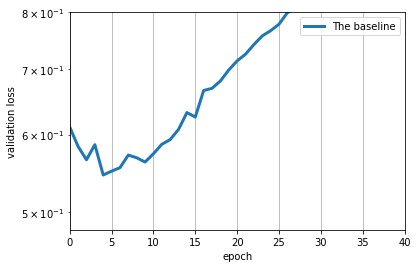

In [12]:
valid_loss1 = net1.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.48, 0.8)
plt.yscale("log")
plt.show()

Note that with the increase in number of epochs the validation error keeps on increasing even though the training loss is decreasing with the number of epochs, this is primarily hinting towards over-fitting.

# Increase dropout

Add some drop out to prevent overfitting.

In [13]:
increasedDropout = 0.4
model2 = getModel(increasedDropout)
net2 = model2.fit(X, y, epochs=100, batch_size=512, verbose=2,validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/100
 - 1s - loss: 1.3921 - acc: 0.6553 - val_loss: 0.6453 - val_acc: 0.7584
Epoch 2/100
 - 1s - loss: 0.6777 - acc: 0.7437 - val_loss: 0.5949 - val_acc: 0.7720
Epoch 3/100
 - 1s - loss: 0.6311 - acc: 0.7623 - val_loss: 0.5794 - val_acc: 0.7742
Epoch 4/100
 - 1s - loss: 0.6004 - acc: 0.7691 - val_loss: 0.5770 - val_acc: 0.7795
Epoch 5/100
 - 1s - loss: 0.5780 - acc: 0.7783 - val_loss: 0.5640 - val_acc: 0.7828
Epoch 6/100
 - 1s - loss: 0.5582 - acc: 0.7851 - val_loss: 0.5604 - val_acc: 0.7829
Epoch 7/100
 - 1s - loss: 0.5442 - acc: 0.7904 - val_loss: 0.5517 - val_acc: 0.7879
Epoch 8/100
 - 1s - loss: 0.5324 - acc: 0.7921 - val_loss: 0.5526 - val_acc: 0.7852
Epoch 9/100
 - 1s - loss: 0.5134 - acc: 0.8001 - val_loss: 0.5493 - val_acc: 0.7865
Epoch 10/100
 - 1s - loss: 0.5023 - acc: 0.8062 - val_loss: 0.5407 - val_acc: 0.7885
Epoch 11/100
 - 1s - loss: 0.4947 - acc: 0.8067 - val_loss: 0.5445 - val_acc: 0.7876
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 1s - loss: 0.2044 - acc: 0.9208 - val_loss: 0.7446 - val_acc: 0.7896
Epoch 98/100
 - 1s - loss: 0.2020 - acc: 0.9218 - val_loss: 0.7477 - val_acc: 0.7905
Epoch 99/100
 - 1s - loss: 0.1984 - acc: 0.9221 - val_loss: 0.7538 - val_acc: 0.7940
Epoch 100/100
 - 1s - loss: 0.2017 - acc: 0.9217 - val_loss: 0.7454 - val_acc: 0.7923


Here we see that the results have improved fairly with using the drop out value of 0.4, further the best validation loss score is obtained at around 13th epoch with the val_loss around 0.5318

Compare validation loss for *net1* and *net2*

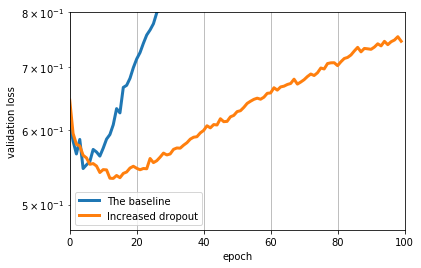

best validation loss 0.5329629761664878


In [14]:
valid_loss2 = net2.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
plt.plot(valid_loss2, linewidth=3, label="Increased dropout")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 100)
plt.ylim(0.47, 0.8)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss2))

That is better. <br>
No more overfitting, and it feels like it is possible to increase number of epochs.

# Increase number of neurons

Increase number of neurons in the first hidden layer.

In [15]:
increasedNeurons1 = 1000
model4 = getModel(increasedDropout, neurons1=increasedNeurons1)
net4 = model4.fit(X, y, epochs=100, batch_size=512, verbose=2, validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/100
 - 2s - loss: 2.1256 - acc: 0.6322 - val_loss: 0.6377 - val_acc: 0.7628
Epoch 2/100
 - 2s - loss: 0.6482 - acc: 0.7537 - val_loss: 0.5852 - val_acc: 0.7782
Epoch 3/100
 - 1s - loss: 0.5970 - acc: 0.7718 - val_loss: 0.5678 - val_acc: 0.7808
Epoch 4/100
 - 2s - loss: 0.5684 - acc: 0.7820 - val_loss: 0.5690 - val_acc: 0.7788
Epoch 5/100
 - 2s - loss: 0.5401 - acc: 0.7905 - val_loss: 0.5453 - val_acc: 0.7885
Epoch 6/100
 - 2s - loss: 0.5225 - acc: 0.7957 - val_loss: 0.5441 - val_acc: 0.7910
Epoch 7/100
 - 2s - loss: 0.5022 - acc: 0.8022 - val_loss: 0.5416 - val_acc: 0.7931
Epoch 8/100
 - 2s - loss: 0.4871 - acc: 0.8082 - val_loss: 0.5458 - val_acc: 0.7897
Epoch 9/100
 - 2s - loss: 0.4713 - acc: 0.8143 - val_loss: 0.5420 - val_acc: 0.7932
Epoch 10/100
 - 1s - loss: 0.4548 - acc: 0.8182 - val_loss: 0.5307 - val_acc: 0.7963
Epoch 11/100
 - 1s - loss: 0.4420 - acc: 0.8259 - val_loss: 0.5364 - val_acc: 0.7936
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 1s - loss: 0.1030 - acc: 0.9630 - val_loss: 0.8922 - val_acc: 0.7889
Epoch 98/100
 - 1s - loss: 0.1032 - acc: 0.9607 - val_loss: 0.8883 - val_acc: 0.7926
Epoch 99/100
 - 1s - loss: 0.1054 - acc: 0.9615 - val_loss: 0.8950 - val_acc: 0.7916
Epoch 100/100
 - 1s - loss: 0.1041 - acc: 0.9613 - val_loss: 0.9006 - val_acc: 0.7923


With the increased number of neurons in the first layer we see that the validation loss value has reached to 0.5280

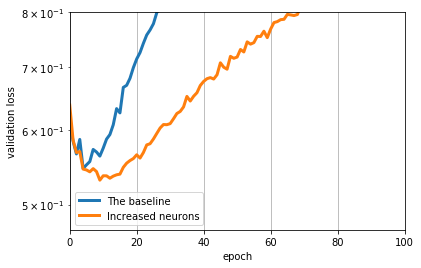

best validation loss 0.5306921957160273


In [16]:
valid_loss4 = net4.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
#plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 100)
plt.ylim(0.47, 0.8)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss4))

# Decrease learning rate

To prevent overfitting decrease the learning rate.

In [17]:
model5 = getModel(increasedDropout, neurons1=increasedNeurons1, learningRate=0.008)
net5 = model5.fit(X, y, epochs=300, batch_size=512, verbose=2, validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/300
 - 2s - loss: 0.8451 - acc: 0.6974 - val_loss: 0.6203 - val_acc: 0.7654
Epoch 2/300
 - 1s - loss: 0.6398 - acc: 0.7584 - val_loss: 0.5897 - val_acc: 0.7757
Epoch 3/300
 - 1s - loss: 0.6038 - acc: 0.7708 - val_loss: 0.5735 - val_acc: 0.7790
Epoch 4/300
 - 1s - loss: 0.5826 - acc: 0.7775 - val_loss: 0.5713 - val_acc: 0.7794
Epoch 5/300
 - 1s - loss: 0.5641 - acc: 0.7874 - val_loss: 0.5570 - val_acc: 0.7851
Epoch 6/300
 - 2s - loss: 0.5513 - acc: 0.7879 - val_loss: 0.5530 - val_acc: 0.7860
Epoch 7/300
 - 1s - loss: 0.5393 - acc: 0.7918 - val_loss: 0.5484 - val_acc: 0.7896
Epoch 8/300
 - 1s - loss: 0.5303 - acc: 0.7956 - val_loss: 0.5472 - val_acc: 0.7858
Epoch 9/300
 - 1s - loss: 0.5223 - acc: 0.7988 - val_loss: 0.5421 - val_acc: 0.7922
Epoch 10/300
 - 1s - loss: 0.5109 - acc: 0.8031 - val_loss: 0.5385 - val_acc: 0.7925
Epoch 11/300
 - 1s - loss: 0.5040 - acc: 0.8068 - val_loss: 0.5379 - val_acc: 0.7911
Epoch 12/300
 - 1s - loss

Epoch 97/300
 - 2s - loss: 0.2746 - acc: 0.8926 - val_loss: 0.5619 - val_acc: 0.8011
Epoch 98/300
 - 2s - loss: 0.2751 - acc: 0.8928 - val_loss: 0.5630 - val_acc: 0.8029
Epoch 99/300
 - 2s - loss: 0.2710 - acc: 0.8943 - val_loss: 0.5661 - val_acc: 0.8025
Epoch 100/300
 - 2s - loss: 0.2724 - acc: 0.8913 - val_loss: 0.5651 - val_acc: 0.8028
Epoch 101/300
 - 2s - loss: 0.2696 - acc: 0.8969 - val_loss: 0.5655 - val_acc: 0.8009
Epoch 102/300
 - 2s - loss: 0.2679 - acc: 0.8960 - val_loss: 0.5662 - val_acc: 0.8005
Epoch 103/300
 - 2s - loss: 0.2640 - acc: 0.8962 - val_loss: 0.5690 - val_acc: 0.8018
Epoch 104/300
 - 2s - loss: 0.2673 - acc: 0.8961 - val_loss: 0.5675 - val_acc: 0.8002
Epoch 105/300
 - 2s - loss: 0.2683 - acc: 0.8938 - val_loss: 0.5702 - val_acc: 0.8023
Epoch 106/300
 - 2s - loss: 0.2660 - acc: 0.8960 - val_loss: 0.5679 - val_acc: 0.8014
Epoch 107/300
 - 2s - loss: 0.2656 - acc: 0.8956 - val_loss: 0.5683 - val_acc: 0.8007
Epoch 108/300
 - 2s - loss: 0.2646 - acc: 0.8972 - val_lo

Epoch 193/300
 - 2s - loss: 0.2056 - acc: 0.9198 - val_loss: 0.6249 - val_acc: 0.8003
Epoch 194/300
 - 2s - loss: 0.2038 - acc: 0.9200 - val_loss: 0.6271 - val_acc: 0.8016
Epoch 195/300
 - 2s - loss: 0.2024 - acc: 0.9219 - val_loss: 0.6260 - val_acc: 0.8020
Epoch 196/300
 - 2s - loss: 0.2030 - acc: 0.9220 - val_loss: 0.6271 - val_acc: 0.8009
Epoch 197/300
 - 2s - loss: 0.1992 - acc: 0.9244 - val_loss: 0.6285 - val_acc: 0.7996
Epoch 198/300
 - 2s - loss: 0.2012 - acc: 0.9225 - val_loss: 0.6318 - val_acc: 0.7990
Epoch 199/300
 - 2s - loss: 0.2009 - acc: 0.9230 - val_loss: 0.6315 - val_acc: 0.7994
Epoch 200/300
 - 2s - loss: 0.2030 - acc: 0.9207 - val_loss: 0.6296 - val_acc: 0.7997
Epoch 201/300
 - 2s - loss: 0.1974 - acc: 0.9239 - val_loss: 0.6334 - val_acc: 0.8002
Epoch 202/300
 - 1s - loss: 0.2011 - acc: 0.9249 - val_loss: 0.6332 - val_acc: 0.8000
Epoch 203/300
 - 1s - loss: 0.2001 - acc: 0.9234 - val_loss: 0.6357 - val_acc: 0.7997
Epoch 204/300
 - 2s - loss: 0.1969 - acc: 0.9250 - val

Epoch 289/300
 - 2s - loss: 0.1640 - acc: 0.9367 - val_loss: 0.6767 - val_acc: 0.7992
Epoch 290/300
 - 2s - loss: 0.1672 - acc: 0.9358 - val_loss: 0.6775 - val_acc: 0.7977
Epoch 291/300
 - 2s - loss: 0.1697 - acc: 0.9366 - val_loss: 0.6763 - val_acc: 0.7974
Epoch 292/300
 - 2s - loss: 0.1632 - acc: 0.9385 - val_loss: 0.6787 - val_acc: 0.7997
Epoch 293/300
 - 2s - loss: 0.1669 - acc: 0.9365 - val_loss: 0.6804 - val_acc: 0.7974
Epoch 294/300
 - 2s - loss: 0.1672 - acc: 0.9347 - val_loss: 0.6805 - val_acc: 0.7989
Epoch 295/300
 - 2s - loss: 0.1713 - acc: 0.9328 - val_loss: 0.6774 - val_acc: 0.7989
Epoch 296/300
 - 2s - loss: 0.1661 - acc: 0.9365 - val_loss: 0.6807 - val_acc: 0.7997
Epoch 297/300
 - 2s - loss: 0.1689 - acc: 0.9348 - val_loss: 0.6797 - val_acc: 0.7986
Epoch 298/300
 - 2s - loss: 0.1626 - acc: 0.9386 - val_loss: 0.6827 - val_acc: 0.7966
Epoch 299/300
 - 2s - loss: 0.1642 - acc: 0.9381 - val_loss: 0.6822 - val_acc: 0.7978
Epoch 300/300
 - 2s - loss: 0.1667 - acc: 0.9365 - val

In [18]:
#checking the best validation loss after decreasing the learning rate
valid_loss5 = min(net5.history["val_loss"])
print(valid_loss5)

0.519600273558755


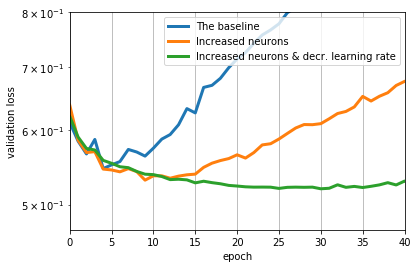

best validation loss 0.519600273558755


In [19]:
valid_loss5 = net5.history["val_loss"]
plt.plot(valid_loss1, linewidth=3, label="The baseline")
#plt.plot(valid_loss3, linewidth=3, label="Increased dropout & epoch")
plt.plot(valid_loss4, linewidth=3, label="Increased neurons")
plt.plot(valid_loss5, linewidth=3, label="Increased neurons & decr. learning rate")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 40)
plt.ylim(0.47, 0.8)
plt.yscale("log")
plt.show()
print('best validation loss', min(valid_loss5))

Low learning rate smoothed down validation loss curve and improved prediction quality. 
Now there is a good balance between number of neurons, dropout and learning rate. <br>
Note that other parameters could have been tuned too: number of layers, activation function etc.

I tried increasing the number of layers and checking if there was any improvement validation loss. The results are:
+ With 5 layers and learning rate of 0.004, with 500 epochs the validation loss was 0.5421819078270516
+ With 4 layers and learning rate of 0.004, with 500 epochs the validation loss was 0.5330044831748673
+ With 3 layers and learning rate of 0.004, with 500 epochs the validation loss was 0.5290813801692954
+ neuron1 =500, 0.5284347782959894

In [20]:
#incrreasing the number of layers in the nn
def getModel2(dropout=0.4, neurons1=500, neurons2=250,neurons3=250,
             learningRate=0.004):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(neurons3, activation='relu', name='Dense_3'))
    model.add(Dropout(dropout, name='Dropout_3'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adagrad(lr=learningRate), metrics=['accuracy'])
    return model

model2 = getModel2()

#SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [21]:
model2 = getModel2(increasedDropout)
net7 = model2.fit(X, y, epochs=500, batch_size=512, verbose=2,validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/500
 - 2s - loss: 0.9818 - acc: 0.6551 - val_loss: 0.6923 - val_acc: 0.7409
Epoch 2/500
 - 1s - loss: 0.7619 - acc: 0.7193 - val_loss: 0.6448 - val_acc: 0.7552
Epoch 3/500
 - 1s - loss: 0.7214 - acc: 0.7307 - val_loss: 0.6266 - val_acc: 0.7628
Epoch 4/500
 - 1s - loss: 0.6993 - acc: 0.7360 - val_loss: 0.6192 - val_acc: 0.7646
Epoch 5/500
 - 1s - loss: 0.6784 - acc: 0.7449 - val_loss: 0.6114 - val_acc: 0.7657
Epoch 6/500
 - 1s - loss: 0.6670 - acc: 0.7466 - val_loss: 0.6033 - val_acc: 0.7683
Epoch 7/500
 - 1s - loss: 0.6596 - acc: 0.7505 - val_loss: 0.5975 - val_acc: 0.7703
Epoch 8/500
 - 1s - loss: 0.6474 - acc: 0.7536 - val_loss: 0.5895 - val_acc: 0.7746
Epoch 9/500
 - 1s - loss: 0.6429 - acc: 0.7558 - val_loss: 0.5868 - val_acc: 0.7759
Epoch 10/500
 - 1s - loss: 0.6343 - acc: 0.7606 - val_loss: 0.5853 - val_acc: 0.7729
Epoch 11/500
 - 1s - loss: 0.6302 - acc: 0.7602 - val_loss: 0.5818 - val_acc: 0.7768
Epoch 12/500
 - 1s - loss

Epoch 97/500
 - 1s - loss: 0.4851 - acc: 0.8096 - val_loss: 0.5306 - val_acc: 0.7957
Epoch 98/500
 - 1s - loss: 0.4838 - acc: 0.8092 - val_loss: 0.5314 - val_acc: 0.7956
Epoch 99/500
 - 1s - loss: 0.4804 - acc: 0.8091 - val_loss: 0.5311 - val_acc: 0.7956
Epoch 100/500
 - 1s - loss: 0.4829 - acc: 0.8083 - val_loss: 0.5316 - val_acc: 0.7956
Epoch 101/500
 - 1s - loss: 0.4808 - acc: 0.8111 - val_loss: 0.5323 - val_acc: 0.7951
Epoch 102/500
 - 2s - loss: 0.4844 - acc: 0.8088 - val_loss: 0.5308 - val_acc: 0.7954
Epoch 103/500
 - 2s - loss: 0.4816 - acc: 0.8101 - val_loss: 0.5307 - val_acc: 0.7948
Epoch 104/500
 - 1s - loss: 0.4779 - acc: 0.8110 - val_loss: 0.5309 - val_acc: 0.7952
Epoch 105/500
 - 1s - loss: 0.4776 - acc: 0.8107 - val_loss: 0.5306 - val_acc: 0.7961
Epoch 106/500
 - 1s - loss: 0.4774 - acc: 0.8084 - val_loss: 0.5307 - val_acc: 0.7956
Epoch 107/500
 - 1s - loss: 0.4757 - acc: 0.8112 - val_loss: 0.5303 - val_acc: 0.7962
Epoch 108/500
 - 1s - loss: 0.4777 - acc: 0.8119 - val_lo

Epoch 193/500
 - 1s - loss: 0.4263 - acc: 0.8283 - val_loss: 0.5304 - val_acc: 0.7959
Epoch 194/500
 - 1s - loss: 0.4275 - acc: 0.8303 - val_loss: 0.5304 - val_acc: 0.7973
Epoch 195/500
 - 1s - loss: 0.4293 - acc: 0.8271 - val_loss: 0.5306 - val_acc: 0.7968
Epoch 196/500
 - 1s - loss: 0.4289 - acc: 0.8268 - val_loss: 0.5304 - val_acc: 0.7961
Epoch 197/500
 - 1s - loss: 0.4235 - acc: 0.8291 - val_loss: 0.5314 - val_acc: 0.7961
Epoch 198/500
 - 1s - loss: 0.4259 - acc: 0.8293 - val_loss: 0.5308 - val_acc: 0.7968
Epoch 199/500
 - 1s - loss: 0.4269 - acc: 0.8256 - val_loss: 0.5313 - val_acc: 0.7961
Epoch 200/500
 - 1s - loss: 0.4245 - acc: 0.8302 - val_loss: 0.5310 - val_acc: 0.7976
Epoch 201/500
 - 1s - loss: 0.4261 - acc: 0.8289 - val_loss: 0.5312 - val_acc: 0.7966
Epoch 202/500
 - 1s - loss: 0.4266 - acc: 0.8283 - val_loss: 0.5313 - val_acc: 0.7969
Epoch 203/500
 - 1s - loss: 0.4268 - acc: 0.8280 - val_loss: 0.5312 - val_acc: 0.7972
Epoch 204/500
 - 1s - loss: 0.4233 - acc: 0.8313 - val

Epoch 289/500
 - 1s - loss: 0.3935 - acc: 0.8396 - val_loss: 0.5359 - val_acc: 0.7982
Epoch 290/500
 - 1s - loss: 0.3965 - acc: 0.8400 - val_loss: 0.5360 - val_acc: 0.7985
Epoch 291/500
 - 1s - loss: 0.3972 - acc: 0.8376 - val_loss: 0.5356 - val_acc: 0.7986
Epoch 292/500
 - 1s - loss: 0.3956 - acc: 0.8394 - val_loss: 0.5361 - val_acc: 0.7979
Epoch 293/500
 - 1s - loss: 0.3948 - acc: 0.8400 - val_loss: 0.5364 - val_acc: 0.7972
Epoch 294/500
 - 1s - loss: 0.3928 - acc: 0.8419 - val_loss: 0.5367 - val_acc: 0.7985
Epoch 295/500
 - 1s - loss: 0.3933 - acc: 0.8401 - val_loss: 0.5370 - val_acc: 0.7976
Epoch 296/500
 - 1s - loss: 0.3904 - acc: 0.8431 - val_loss: 0.5366 - val_acc: 0.7984
Epoch 297/500
 - 1s - loss: 0.3930 - acc: 0.8402 - val_loss: 0.5365 - val_acc: 0.7986
Epoch 298/500
 - 1s - loss: 0.3924 - acc: 0.8414 - val_loss: 0.5369 - val_acc: 0.7984
Epoch 299/500
 - 1s - loss: 0.3956 - acc: 0.8401 - val_loss: 0.5367 - val_acc: 0.7991
Epoch 300/500
 - 1s - loss: 0.3891 - acc: 0.8421 - val

Epoch 385/500
 - 1s - loss: 0.3677 - acc: 0.8519 - val_loss: 0.5440 - val_acc: 0.7997
Epoch 386/500
 - 1s - loss: 0.3654 - acc: 0.8523 - val_loss: 0.5446 - val_acc: 0.7994
Epoch 387/500
 - 1s - loss: 0.3689 - acc: 0.8504 - val_loss: 0.5444 - val_acc: 0.7997
Epoch 388/500
 - 1s - loss: 0.3644 - acc: 0.8530 - val_loss: 0.5445 - val_acc: 0.7997
Epoch 389/500
 - 1s - loss: 0.3675 - acc: 0.8495 - val_loss: 0.5445 - val_acc: 0.7995
Epoch 390/500
 - 1s - loss: 0.3652 - acc: 0.8513 - val_loss: 0.5448 - val_acc: 0.7994
Epoch 391/500
 - 1s - loss: 0.3689 - acc: 0.8503 - val_loss: 0.5448 - val_acc: 0.7990
Epoch 392/500
 - 1s - loss: 0.3728 - acc: 0.8515 - val_loss: 0.5442 - val_acc: 0.7995
Epoch 393/500
 - 1s - loss: 0.3676 - acc: 0.8513 - val_loss: 0.5446 - val_acc: 0.7994
Epoch 394/500
 - 1s - loss: 0.3685 - acc: 0.8499 - val_loss: 0.5446 - val_acc: 0.7989
Epoch 395/500
 - 1s - loss: 0.3690 - acc: 0.8496 - val_loss: 0.5441 - val_acc: 0.7997
Epoch 396/500
 - 1s - loss: 0.3645 - acc: 0.8523 - val

Epoch 481/500
 - 1s - loss: 0.3511 - acc: 0.8555 - val_loss: 0.5532 - val_acc: 0.7989
Epoch 482/500
 - 1s - loss: 0.3519 - acc: 0.8581 - val_loss: 0.5536 - val_acc: 0.7986
Epoch 483/500
 - 1s - loss: 0.3514 - acc: 0.8575 - val_loss: 0.5531 - val_acc: 0.7985
Epoch 484/500
 - 1s - loss: 0.3508 - acc: 0.8572 - val_loss: 0.5532 - val_acc: 0.7990
Epoch 485/500
 - 1s - loss: 0.3479 - acc: 0.8579 - val_loss: 0.5537 - val_acc: 0.8001
Epoch 486/500
 - 1s - loss: 0.3484 - acc: 0.8595 - val_loss: 0.5535 - val_acc: 0.7988
Epoch 487/500
 - 1s - loss: 0.3510 - acc: 0.8578 - val_loss: 0.5536 - val_acc: 0.8000
Epoch 488/500
 - 1s - loss: 0.3474 - acc: 0.8571 - val_loss: 0.5534 - val_acc: 0.7984
Epoch 489/500
 - 1s - loss: 0.3477 - acc: 0.8586 - val_loss: 0.5536 - val_acc: 0.7996
Epoch 490/500
 - 1s - loss: 0.3493 - acc: 0.8572 - val_loss: 0.5534 - val_acc: 0.7989
Epoch 491/500
 - 1s - loss: 0.3516 - acc: 0.8572 - val_loss: 0.5527 - val_acc: 0.7997
Epoch 492/500
 - 1s - loss: 0.3480 - acc: 0.8588 - val

In [22]:
#checking the best validation loss after decreasing the learning rate
valid_loss7 = min(net7.history["val_loss"])
print(valid_loss7)

0.5285650968970725


# Tuning hyperparameters with grid search

Keras sequential models (single-input only) can be used in *scikit-learn* by wrapping them with the *KerasClassifier* or *KerasRegressor* class.

To use these wrappers you must define a function that creates and returns your Keras sequential model, then pass this function to the *build_fn* argument when constructing the KerasClassifier class. *build_fn* should construct, compile and return a Keras model, which will then be used to fit/predict. One of the following three values could be passed to build_fn:  

- A function
- An instance of a class that implements the call method
- None. This means you implement a class that inherits from either KerasClassifier or KerasRegressor. The call method of the present class will then be treated as the default *build_fn*.

E.g. we can create KerasClassifier instance with the above defined function *getModel* :

In [23]:
model = KerasClassifier(build_fn=getModel)

The constructor for the KerasClassifier class take second argument   
*ssk_params*: model parameters & fitting parameters.  
We can pass there any legal model and fitting parameters. 

In [24]:
model = KerasClassifier(build_fn=getModel, epochs=200, batch_size=512, verbose=0)
model.get_params()

{'batch_size': 512,
 'build_fn': <function __main__.getModel>,
 'epochs': 200,
 'verbose': 0}

Since it is now scikit-learn Classifier, we can use Grid search - a model hyperparameter optimization technique provided in scikit-learn GridSearchCV class.  

When constructing this class we provide a dictionary of hyperparameters to evaluate in the param_grid argument.

By default, the grid search will only use one thread. <br>
By setting the *n_jobs* argument in the *GridSearchCV* constructor to -1, the process will use all cores on your machine. <br>
If *n_jobs* was set to a value higher than one, the data are copied for each point in the grid (and not *n_jobs* times). <br>
This is done for efficiency if individual jobs take very little time, but may raise errors if the dataset is large and there is not enough memory available. <br>
A workaround in this case is to set pre_dispatch. <br>
Then, the memory is copied only pre_dispatch many times. <br>
A reasonable value for pre_dispatch is $2~\times~$n_jobs.

The *GridSearchCV* process will then construct and evaluate one model for each combination of parameters. <br>
Cross validation is used to evaluate each individual model and the default of 3-fold cross validation is used, although this can be overridden by specifying the cv argument to the GridSearchCV constructor.  

We set "neg_log_loss" (negative logloss) as a scoring measure since  *GridSearchCV* is trying to maximize score.

In [25]:
# define the grid search parameters
param_grid = dict(dropout=[0.1, 0.2, 0.3], neurons1=[300, 500, 700])

grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                    scoring="neg_log_loss", n_jobs=1)

In [26]:
grid_result = grid.fit(X, y)

We can extract results from *grid_result* attribute *cv_results_*. 

Recall that we were maximizing negative logloss. So, we output *-mean*  as logloss mean.

In [27]:
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.969491 using {'dropout': 0.3, 'neurons1': 300}
1.432594 (0.019329) with: {'dropout': 0.1, 'neurons1': 300}
1.651521 (0.037130) with: {'dropout': 0.1, 'neurons1': 500}
1.714247 (0.054301) with: {'dropout': 0.1, 'neurons1': 700}
1.163371 (0.010785) with: {'dropout': 0.2, 'neurons1': 300}
1.411013 (0.031086) with: {'dropout': 0.2, 'neurons1': 500}
1.537629 (0.057455) with: {'dropout': 0.2, 'neurons1': 700}
0.969491 (0.015789) with: {'dropout': 0.3, 'neurons1': 300}
1.213389 (0.016753) with: {'dropout': 0.3, 'neurons1': 500}
1.315439 (0.080900) with: {'dropout': 0.3, 'neurons1': 700}


# Selecting Optimization Algorithm

Grid search may be applied not only to numerical parameters. 

We can find the best optimizer using it.

In [28]:
def getModel1(dropout=0.1, neurons1=500, neurons2=250,optimizer="Adagrad"):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features))
    model.add(Dropout(dropout))
    model.add(Dense(neurons2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# create model
model = KerasClassifier(build_fn=getModel1, dropout=0.3, neurons1=300,
                        epochs=20, batch_size=512, verbose=0)
# define the grid search parameters

grid = GridSearchCV(estimator=model, param_grid=dict(optimizer=optimizer),
                    scoring="neg_log_loss",n_jobs=1)

In [29]:
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (-grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.545733 using {'optimizer': 'Adam'}
0.796686 (0.005469) with: {'optimizer': 'SGD'}
0.555684 (0.002417) with: {'optimizer': 'RMSprop'}
0.553144 (0.004310) with: {'optimizer': 'Adagrad'}
0.556329 (0.003893) with: {'optimizer': 'Adadelta'}
0.545733 (0.005981) with: {'optimizer': 'Adam'}
0.552629 (0.005630) with: {'optimizer': 'Adamax'}
0.569726 (0.001170) with: {'optimizer': 'Nadam'}


The results dont seemt to be significantly being improved, however we can select the best optimizer from the above results and tweak the architecture a bit more to obtain better results. Lets see, how the network behaves with an increased dropout rate and decreasing the number of neurons in the network. Decreasing the number of neurons in the network will be helpful as we have lower number of parameters to estimate and given that our data set is not huge, we might be able to get better results. 

In [30]:
#incrreasing the number of layers in the nn
def getModel3(dropout=0.4, neurons1=300, neurons2=250,neurons3=250,
             learningRate=0.008):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(neurons3, activation='relu', name='Dense_3'))
    model.add(Dropout(dropout, name='Dropout_3'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=learningRate), metrics=['accuracy'])
    return model

model3 = getModel3()

#SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [31]:
net8 = model3.fit(X, y, epochs=300, batch_size=512, verbose=2,validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/300
 - 3s - loss: 0.9022 - acc: 0.6808 - val_loss: 0.6524 - val_acc: 0.7609
Epoch 2/300
 - 1s - loss: 0.6946 - acc: 0.7423 - val_loss: 0.6082 - val_acc: 0.7721
Epoch 3/300
 - 1s - loss: 0.6554 - acc: 0.7559 - val_loss: 0.5903 - val_acc: 0.7739
Epoch 4/300
 - 1s - loss: 0.6390 - acc: 0.7573 - val_loss: 0.5910 - val_acc: 0.7761
Epoch 5/300
 - 1s - loss: 0.6246 - acc: 0.7623 - val_loss: 0.6051 - val_acc: 0.7626
Epoch 6/300
 - 1s - loss: 0.6097 - acc: 0.7683 - val_loss: 0.5849 - val_acc: 0.7806
Epoch 7/300
 - 1s - loss: 0.5998 - acc: 0.7705 - val_loss: 0.5819 - val_acc: 0.7751
Epoch 8/300
 - 1s - loss: 0.5911 - acc: 0.7759 - val_loss: 0.5783 - val_acc: 0.7786
Epoch 9/300
 - 1s - loss: 0.5868 - acc: 0.7768 - val_loss: 0.5760 - val_acc: 0.7808
Epoch 10/300
 - 2s - loss: 0.5834 - acc: 0.7760 - val_loss: 0.5702 - val_acc: 0.7802
Epoch 11/300
 - 1s - loss: 0.5757 - acc: 0.7810 - val_loss: 0.5698 - val_acc: 0.7874
Epoch 12/300
 - 1s - loss

Epoch 97/300
 - 1s - loss: 0.4450 - acc: 0.8291 - val_loss: 0.6304 - val_acc: 0.7894
Epoch 98/300
 - 1s - loss: 0.4463 - acc: 0.8322 - val_loss: 0.6301 - val_acc: 0.7875
Epoch 99/300
 - 1s - loss: 0.4425 - acc: 0.8319 - val_loss: 0.6343 - val_acc: 0.7864
Epoch 100/300
 - 1s - loss: 0.4494 - acc: 0.8275 - val_loss: 0.6300 - val_acc: 0.7825
Epoch 101/300
 - 1s - loss: 0.4454 - acc: 0.8331 - val_loss: 0.6294 - val_acc: 0.7854
Epoch 102/300
 - 1s - loss: 0.4393 - acc: 0.8313 - val_loss: 0.6223 - val_acc: 0.7855
Epoch 103/300
 - 1s - loss: 0.4430 - acc: 0.8322 - val_loss: 0.6281 - val_acc: 0.7801
Epoch 104/300
 - 1s - loss: 0.4424 - acc: 0.8329 - val_loss: 0.6295 - val_acc: 0.7842
Epoch 105/300
 - 1s - loss: 0.4440 - acc: 0.8319 - val_loss: 0.6345 - val_acc: 0.7883
Epoch 106/300
 - 1s - loss: 0.4454 - acc: 0.8315 - val_loss: 0.6235 - val_acc: 0.7880
Epoch 107/300
 - 1s - loss: 0.4359 - acc: 0.8344 - val_loss: 0.6220 - val_acc: 0.7885
Epoch 108/300
 - 1s - loss: 0.4316 - acc: 0.8382 - val_lo

Epoch 193/300
 - 1s - loss: 0.4089 - acc: 0.8460 - val_loss: 0.7039 - val_acc: 0.7853
Epoch 194/300
 - 1s - loss: 0.4088 - acc: 0.8471 - val_loss: 0.6863 - val_acc: 0.7885
Epoch 195/300
 - 1s - loss: 0.4053 - acc: 0.8465 - val_loss: 0.6943 - val_acc: 0.7870
Epoch 196/300
 - 1s - loss: 0.3974 - acc: 0.8499 - val_loss: 0.7092 - val_acc: 0.7847
Epoch 197/300
 - 1s - loss: 0.4036 - acc: 0.8473 - val_loss: 0.7083 - val_acc: 0.7785
Epoch 198/300
 - 1s - loss: 0.3972 - acc: 0.8494 - val_loss: 0.6970 - val_acc: 0.7852
Epoch 199/300
 - 1s - loss: 0.3938 - acc: 0.8521 - val_loss: 0.7129 - val_acc: 0.7853
Epoch 200/300
 - 1s - loss: 0.4054 - acc: 0.8486 - val_loss: 0.6843 - val_acc: 0.7897
Epoch 201/300
 - 1s - loss: 0.3963 - acc: 0.8498 - val_loss: 0.7171 - val_acc: 0.7853
Epoch 202/300
 - 1s - loss: 0.4025 - acc: 0.8494 - val_loss: 0.6916 - val_acc: 0.7881
Epoch 203/300
 - 1s - loss: 0.4017 - acc: 0.8478 - val_loss: 0.6907 - val_acc: 0.7859
Epoch 204/300
 - 1s - loss: 0.4045 - acc: 0.8494 - val

Epoch 289/300
 - 1s - loss: 0.3953 - acc: 0.8560 - val_loss: 0.7597 - val_acc: 0.7812
Epoch 290/300
 - 1s - loss: 0.3897 - acc: 0.8563 - val_loss: 0.7383 - val_acc: 0.7871
Epoch 291/300
 - 1s - loss: 0.3914 - acc: 0.8566 - val_loss: 0.7619 - val_acc: 0.7823
Epoch 292/300
 - 1s - loss: 0.3889 - acc: 0.8546 - val_loss: 0.7459 - val_acc: 0.7818
Epoch 293/300
 - 1s - loss: 0.3879 - acc: 0.8546 - val_loss: 0.7890 - val_acc: 0.7840
Epoch 294/300
 - 1s - loss: 0.3912 - acc: 0.8575 - val_loss: 0.7684 - val_acc: 0.7828
Epoch 295/300
 - 1s - loss: 0.3952 - acc: 0.8558 - val_loss: 0.7509 - val_acc: 0.7837
Epoch 296/300
 - 1s - loss: 0.3765 - acc: 0.8597 - val_loss: 0.7714 - val_acc: 0.7819
Epoch 297/300
 - 1s - loss: 0.3804 - acc: 0.8571 - val_loss: 0.7803 - val_acc: 0.7835
Epoch 298/300
 - 1s - loss: 0.3791 - acc: 0.8596 - val_loss: 0.7720 - val_acc: 0.7759
Epoch 299/300
 - 1s - loss: 0.3932 - acc: 0.8538 - val_loss: 0.7582 - val_acc: 0.7830
Epoch 300/300
 - 1s - loss: 0.3855 - acc: 0.8563 - val

In [32]:
#checking the best validation loss after decreasing the learning rate
valid_loss8 = min(net8.history["val_loss"])
print(valid_loss8)

0.5581972258410927


I tried the above architecture with different configurations as well, the results are as follows:
+ 0.5284347782959894, with adam
+ 0.555913948054631, with 1000 nuerons

### This is the final model I used.

It was advised for us that if during training we hit the val loss around 0.52 then we can use it on our test set (this is a different data set we used), for a test log loss for below 0.49 and it worked on my data set. However, I am still going to toy with some of the other parameters and check how they are performing.

Changing the activation function and using tanh activation fucntion, as this used by the team which won this Kaggle Competition. I am also increasing the number of neurons in the first layer in this model.

In [33]:
#incrreasing the number of layers in the nn
def getModel4(dropout=0.4, neurons1=1000, neurons2=250,neurons3=250,
             learningRate=0.08):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='tanh', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='tanh',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(neurons3, activation='tanh', name='Dense_3'))
    model.add(Dropout(dropout, name='Dropout_3'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=learningRate), metrics=['accuracy'])
    return model

model4 = getModel4()

#SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [34]:
net9 = model4.fit(X, y, epochs=300, batch_size=512, verbose=2,validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/300
 - 5s - loss: 8.5039 - acc: 0.2589 - val_loss: 6.8659 - val_acc: 0.4392
Epoch 2/300
 - 2s - loss: 7.1757 - acc: 0.3630 - val_loss: 7.3692 - val_acc: 0.4228
Epoch 3/300
 - 2s - loss: 7.6440 - acc: 0.3368 - val_loss: 8.5924 - val_acc: 0.3411
Epoch 4/300
 - 2s - loss: 8.6096 - acc: 0.3211 - val_loss: 8.6507 - val_acc: 0.4196
Epoch 5/300
 - 2s - loss: 8.5129 - acc: 0.3388 - val_loss: 8.5067 - val_acc: 0.4339
Epoch 6/300
 - 2s - loss: 8.5596 - acc: 0.3314 - val_loss: 8.6991 - val_acc: 0.3457
Epoch 7/300
 - 2s - loss: 8.7261 - acc: 0.2844 - val_loss: 9.5197 - val_acc: 0.1304
Epoch 8/300
 - 2s - loss: 8.8799 - acc: 0.2708 - val_loss: 8.7714 - val_acc: 0.3443
Epoch 9/300
 - 2s - loss: 9.0567 - acc: 0.2242 - val_loss: 9.0726 - val_acc: 0.1297
Epoch 10/300
 - 2s - loss: 8.9189 - acc: 0.2382 - val_loss: 8.7663 - val_acc: 0.2408
Epoch 11/300
 - 2s - loss: 8.6470 - acc: 0.2677 - val_loss: 8.6776 - val_acc: 0.3459
Epoch 12/300
 - 2s - loss

Epoch 97/300
 - 2s - loss: 8.5694 - acc: 0.3093 - val_loss: 8.6362 - val_acc: 0.3427
Epoch 98/300
 - 2s - loss: 8.6847 - acc: 0.2977 - val_loss: 8.6235 - val_acc: 0.3388
Epoch 99/300
 - 2s - loss: 8.6554 - acc: 0.2981 - val_loss: 8.6567 - val_acc: 0.3837
Epoch 100/300
 - 2s - loss: 8.6801 - acc: 0.2859 - val_loss: 8.5674 - val_acc: 0.3640
Epoch 101/300
 - 2s - loss: 8.5203 - acc: 0.3210 - val_loss: 8.6137 - val_acc: 0.3472
Epoch 102/300
 - 2s - loss: 8.5471 - acc: 0.3220 - val_loss: 8.8088 - val_acc: 0.3465
Epoch 103/300
 - 2s - loss: 8.4778 - acc: 0.3382 - val_loss: 8.5752 - val_acc: 0.3996
Epoch 104/300
 - 2s - loss: 8.7199 - acc: 0.2970 - val_loss: 8.7673 - val_acc: 0.3179
Epoch 105/300
 - 2s - loss: 8.8627 - acc: 0.2671 - val_loss: 8.6565 - val_acc: 0.3306
Epoch 106/300
 - 2s - loss: 8.7705 - acc: 0.2697 - val_loss: 8.6372 - val_acc: 0.3446
Epoch 107/300
 - 2s - loss: 8.6791 - acc: 0.2933 - val_loss: 8.6320 - val_acc: 0.2435
Epoch 108/300
 - 2s - loss: 8.5372 - acc: 0.3122 - val_lo

Epoch 193/300
 - 2s - loss: 8.4575 - acc: 0.3629 - val_loss: 8.5254 - val_acc: 0.4284
Epoch 194/300
 - 2s - loss: 8.5420 - acc: 0.3556 - val_loss: 8.9449 - val_acc: 0.3470
Epoch 195/300
 - 2s - loss: 8.5485 - acc: 0.3537 - val_loss: 8.5213 - val_acc: 0.3468
Epoch 196/300
 - 2s - loss: 8.4646 - acc: 0.3586 - val_loss: 8.5025 - val_acc: 0.4285
Epoch 197/300
 - 2s - loss: 8.4432 - acc: 0.3660 - val_loss: 9.0655 - val_acc: 0.3448
Epoch 198/300
 - 2s - loss: 8.5263 - acc: 0.3668 - val_loss: 8.5734 - val_acc: 0.3448
Epoch 199/300
 - 2s - loss: 8.4325 - acc: 0.3780 - val_loss: 8.6126 - val_acc: 0.3462
Epoch 200/300
 - 2s - loss: 8.4980 - acc: 0.3645 - val_loss: 8.5370 - val_acc: 0.4329
Epoch 201/300
 - 2s - loss: 8.4681 - acc: 0.3738 - val_loss: 8.8992 - val_acc: 0.3444
Epoch 202/300
 - 3s - loss: 8.5279 - acc: 0.3448 - val_loss: 8.5034 - val_acc: 0.4288
Epoch 203/300
 - 2s - loss: 8.4577 - acc: 0.3659 - val_loss: 8.4965 - val_acc: 0.4268
Epoch 204/300
 - 2s - loss: 8.5147 - acc: 0.3594 - val

Epoch 289/300
 - 2s - loss: 8.5261 - acc: 0.3642 - val_loss: 8.5309 - val_acc: 0.4376
Epoch 290/300
 - 2s - loss: 8.4856 - acc: 0.3768 - val_loss: 8.5032 - val_acc: 0.4357
Epoch 291/300
 - 2s - loss: 8.4606 - acc: 0.3774 - val_loss: 8.5208 - val_acc: 0.4402
Epoch 292/300
 - 2s - loss: 8.4626 - acc: 0.3810 - val_loss: 8.5656 - val_acc: 0.3466
Epoch 293/300
 - 2s - loss: 8.4813 - acc: 0.3834 - val_loss: 8.5561 - val_acc: 0.4359
Epoch 294/300
 - 2s - loss: 8.4608 - acc: 0.3801 - val_loss: 8.5789 - val_acc: 0.3420
Epoch 295/300
 - 2s - loss: 8.5007 - acc: 0.3718 - val_loss: 8.5321 - val_acc: 0.4301
Epoch 296/300
 - 2s - loss: 8.4594 - acc: 0.3785 - val_loss: 8.7542 - val_acc: 0.3467
Epoch 297/300
 - 2s - loss: 8.4649 - acc: 0.3794 - val_loss: 8.6316 - val_acc: 0.3437
Epoch 298/300
 - 2s - loss: 8.6172 - acc: 0.3637 - val_loss: 8.5287 - val_acc: 0.4359
Epoch 299/300
 - 2s - loss: 8.4558 - acc: 0.3744 - val_loss: 8.6285 - val_acc: 0.3470
Epoch 300/300
 - 2s - loss: 8.4832 - acc: 0.3732 - val

In [35]:
#checking the best validation loss after decreasing the learning rate
valid_loss9 = min(net9.history["val_loss"])
print(valid_loss9)

6.865926019002892


As we increased the number of neurons and with the tanh function, we see that the validation loss for our model has severely suffered and it is not working on our data set, note that our data set contains only 10% of the entire Otto data set, this is another reason for the high validation loss

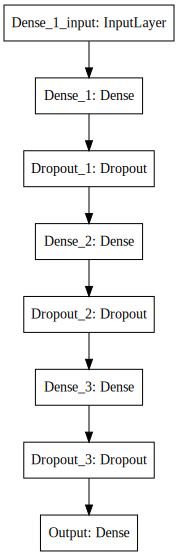

In [40]:
# testing with the winning solution
#incrreasing the number of layers in the nn
def getModel4(dropout=0.4, neurons1=2500, neurons2=1300,neurons3=40,
             learningRate=0.08):
    np.random.seed(1)
    model = Sequential()
    model.add(Dense(neurons1, activation='relu', input_dim=num_features,
                    name='Dense_1'))
    model.add(Dropout(dropout,name='Dropout_1'))
    model.add(Dense(neurons2, activation='relu',name='Dense_2'))
    model.add(Dropout(dropout,name='Dropout_2'))
    model.add(Dense(neurons3, activation='relu', name='Dense_3'))
    model.add(Dropout(dropout, name='Dropout_3'))
    model.add(Dense(num_classes, activation='softmax',name='Output'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=learningRate), metrics=['accuracy'])
    return model

model4 = getModel4()

SVG(model_to_dot(model4).create(prog='dot', format='svg'))

In [41]:
net9 = model4.fit(X, y, epochs=600, batch_size=1024, verbose=2,validation_split=0.2)

Train on 32995 samples, validate on 8249 samples
Epoch 1/600
 - 14s - loss: 11.6625 - acc: 0.2548 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 2/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 3/600
 - 11s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 4/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 5/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 6/600
 - 11s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 7/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 8/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 9/600
 - 10s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 10/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 11/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc:

Epoch 94/600
 - 12s - loss: 11.9688 - acc: 0.2574 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 95/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 96/600
 - 14s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 97/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 98/600
 - 14s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 99/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 100/600
 - 11s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 101/600
 - 13s - loss: 11.9668 - acc: 0.2576 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 102/600
 - 11s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 103/600
 - 11s - loss: 11.9668 - acc: 0.2576 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 104/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 105/600
 - 11s - loss

 - 13s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 187/600
 - 13s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 188/600
 - 13s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 189/600
 - 13s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 190/600
 - 13s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 191/600
 - 13s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 192/600
 - 13s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 193/600
 - 14s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 194/600
 - 13s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 195/600
 - 14s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 196/600
 - 15s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 197/600
 - 17s - loss: 11.967

Epoch 279/600
 - 11s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 280/600
 - 12s - loss: 11.9688 - acc: 0.2574 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 281/600
 - 12s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 282/600
 - 12s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 283/600
 - 11s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 284/600
 - 12s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 285/600
 - 11s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 286/600
 - 11s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 287/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 288/600
 - 11s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 289/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 290/600
 - 12s 

 - 12s - loss: 11.9688 - acc: 0.2574 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 372/600
 - 12s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 373/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 374/600
 - 12s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 375/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 376/600
 - 12s - loss: 11.9673 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 377/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 378/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 379/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 380/600
 - 12s - loss: 11.9688 - acc: 0.2574 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 381/600
 - 13s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 382/600
 - 13s - loss: 11.967

Epoch 464/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 465/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 466/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 467/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 468/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 469/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 470/600
 - 12s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 471/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 472/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 473/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 474/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 475/600
 - 12s 

 - 14s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 557/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 558/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 559/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 560/600
 - 12s - loss: 11.9688 - acc: 0.2574 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 561/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 562/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 563/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 564/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 565/600
 - 12s - loss: 11.9678 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 566/600
 - 12s - loss: 11.9683 - acc: 0.2575 - val_loss: 11.8116 - val_acc: 0.2672
Epoch 567/600
 - 12s - loss: 11.968

In [42]:
#checking the best validation loss after decreasing the learning rate
valid_loss9 = min(net9.history["val_loss"])
print(valid_loss9)

11.811590574830788
